In [39]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [40]:
# PARAMETERS
INPUT_HEIGHT = 128
INPUT_WIDTH = 128

INPUT_SHAPE = (INPUT_HEIGHT, INPUT_WIDTH, 1)

latent_dims = 8



In [41]:
class Preprocessor(tf.keras.Model):
  def __init__(self):
    super().__init__(name="preprocessor")
    self.resizer = tf.keras.layers.Resizing(INPUT_HEIGHT, INPUT_WIDTH, name=f"{self.name}_resizer")
    self.rescaler = tf.keras.layers.Rescaling(scale=1./255, name=f"{self.name}_rescaler")

  def call(self, inputs):
    return self.rescaler(
        self.resizer(inputs)
    )

In [24]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Lambda, Reshape, Conv2DTranspose, BatchNormalization

In [42]:


class Encoder(tf.keras.layers.Layer):
  def __init__(self, latent_dims):
    super().__init__(name="encoder")

    self.latent_dims = latent_dims

    # layers
    self.preprocess = Preprocessor()
    # 128 x 128 x 1
    self.conv1 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu', name='encoder_conv1')
    self.bnorm1 = BatchNormalization(name="encoder_bnorm1")
    self.mpool1 = MaxPool2D(name='encoder_mpool1')

    # 64 x 64 x 128
    self.conv2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', name='encoder_conv2')
    self.bnorm2 = BatchNormalization(name="encoder_bnorm2")
    self.mpool2 = MaxPool2D(name='encoder_mpool2')

    # 32 x 32 x 64
    self.conv3 = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', name='encoder_conv3')
    self.bnorm3 = BatchNormalization(name="encoder_bnorm3")
    self.mpool3 = MaxPool2D(name='encoder_mpool3')

    # 16 x 16 x 32
    self.conv4 = Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='encoder_conv4')
    self.bnorm4 = BatchNormalization(name="encoder_bnorm4")
    self.mpool4 = MaxPool2D(name='encoder_mpool4')

    # 8 x 8 x 16
    self.flatten = Flatten(name='encoder_flatten')

    self.dense1 = Dense(2 * self.latent_dims, name='encoder_dense1')
    # 2 x self.latent_dims


    self.logvar = Dense(self.latent_dims, name='encoder_logvar')
    self.mu = Dense(self.latent_dims, name='encoder_mu')
    self.sigma = Lambda(lambda x: tf.exp(0.5*x), name='encoder_sigma')

  def encode(self, inputs, preprocess=True):
    # print the shape of the input
    # print(f"Shape of input to encoder: {inputs.shape}")
    p = self.preprocess(inputs) if preprocess else inputs
    x=self.conv1(p); x=self.bnorm1(x); x=self.mpool1(x)
    x=self.conv2(x); x=self.bnorm2(x);  x=self.mpool2(x)
    x=self.conv3(x); x=self.bnorm3(x);  x=self.mpool3(x)
    x=self.conv4(x); x=self.bnorm4(x);  x=self.mpool4(x)
    x=self.flatten(x)
    x=self.dense1(x)
    # print(f"Shape of output from encoder: {x.shape}")

    return self.mu(x), self.logvar(x), self.sigma(self.logvar(x)), p


  def call(self, inputs):
    return self.encode(inputs)

  def summary(self, input_shape):
    x = tf.keras.layers.Input(shape=input_shape)
    model = tf.keras.Model(inputs=[x], outputs=self.call(x))
    return model.summary()


In [43]:
class Decoder(tf.keras.Model):
    def __init__(self, latent_dims):
        super().__init__(name='decoder')

        self.latent_dims = latent_dims

        # layers
        self.dense1 = Dense(8 * 8 * 16, activation='relu', name='decoder_dense1')
        self.reshape1 = Reshape((8, 8, 16), name='decoder_reshape1')

        # 8 x 8 x 16 -> 16 x 16 x 32
        self.convT1 = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', activation='relu', name='decoder_convT1')
        self.bnorm1 = BatchNormalization(name="decoder_bnorm1")

        # 16 x 16 x 32 -> 32 x 32 x 64
        self.convT2 = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', name='decoder_convT2')
        self.bnorm2 = BatchNormalization(name="decoder_bnorm2")

        # 32 x 32 x 64 -> 64 x 64 x 128
        self.convT3 = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name='decoder_convT3')
        self.bnorm3 = BatchNormalization(name="decoder_bnorm3")

        # 64 x 64 x 128 -> 128 x 128 x 1
        self.convT4 = Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', activation='relu', name='decoder_convT4')
        self.bnorm4 = BatchNormalization(name="decoder_bnorm4")

        self.output_layer = Conv2D(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid', name='decoder_output')

    def decode(self, z):
        x = self.dense1(z)
        x = self.reshape1(x)

        x = self.convT1(x)
        x = self.bnorm1(x)

        x = self.convT2(x)
        x = self.bnorm2(x)

        x = self.convT3(x)
        x = self.bnorm3(x)

        x = self.convT4(x)
        x = self.bnorm4(x)

        return self.output_layer(x)

    def call(self, inputs):
        return self.decode(inputs)

    def summary(self, input_shape):
        x = tf.keras.layers.Input(shape=input_shape)
        model = tf.keras.Model(inputs=[x], outputs=self.call(x))
        return model.summary()


In [44]:
encoder = Encoder(latent_dims=latent_dims) # Example latent_dims
print("Encoder Summary:")
encoder.summary(input_shape=INPUT_SHAPE)

decoder = Decoder(latent_dims=latent_dims)
print("\nDecoder Summary:")
decoder.summary(input_shape=(latent_dims,))

Encoder Summary:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ preprocessor              │ (None, 128, 128, 1)    │              0 │ input_layer_4[0][0]    │
│ (Preprocessor)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_conv1 (Conv2D)    │ (None, 128, 128, 128)  │          1,280 │ preprocessor[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_bnorm1            │ (None, 128, 128, 128)  │            512 │ encoder_conv1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_mpool1            │ (None, 64, 64, 128)    │              0 │ encoder_bnorm1[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_conv2 (Conv2D)    │ (None, 64, 64, 64)     │         73,792 │ encoder_mpool1[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_bnorm2            │ (None, 64, 64, 64)     │            256 │ encoder_conv2[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_mpool2            │ (None, 32, 32, 64)     │              0 │ encoder_bnorm2[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_conv3 (Conv2D)    │ (None, 32, 32, 32)     │         18,464 │ encoder_mpool2[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_bnorm3            │ (None, 32, 32, 32)     │            128 │ encoder_conv3[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_mpool3            │ (None, 16, 16, 32)     │              0 │ encoder_bnorm3[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_conv4 (Conv2D)    │ (None, 16, 16, 16)     │          4,624 │ encoder_mpool3[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_bnorm4            │ (None, 16, 16, 16)     │             64 │ encoder_conv4[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_mpool4            │ (None, 8, 8, 16)       │              0 │ encoder_bnorm4[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_flatten (Flat

 Total params: 115,792 (452.31 KB)

 Trainable params: 115,312 (450.44 KB)

 Non-trainable params: 480 (1.88 KB)


Decoder Summary:


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_dense1 (Dense)               │ (None, 1024)                │           9,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_reshape1 (Reshape)           │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_convT1 (Conv2DTranspose)     │ (None, 16, 16, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_bnorm1 (BatchNormalization)  │ (None, 16, 16, 16)          │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_convT2 (Conv2DTranspose)     │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_bnorm2 (BatchNormalization)  │ (None, 32, 32, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_convT3 (Conv2DTranspose)     │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_bnorm3 (BatchNormalization)  │ (None, 64, 64, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_convT4 (Conv2DTranspose)     │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_bnorm4 (BatchNormalization)  │ (None, 128, 128, 128)       │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Conv2D)              │ (None, 128, 128, 1)         │           1,153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 110,641 (432.19 KB)

 Trainable params: 110,161 (430.32 KB)

 Non-trainable params: 480 (1.88 KB)

In [45]:
class ReconstructionLoss(tf.keras.layers.Layer):
  def __init__(self):
    super(ReconstructionLoss, self).__init__(name="reconstruction_loss")

  def call(self, inputs):
    x = inputs[0]
    recon_x = inputs[1]

    recon_loss = tf.reduce_sum(tf.keras.losses.binary_crossentropy(x, recon_x), axis=[1,2])
    recon_loss = tf.reduce_mean(recon_loss)

    self.add_loss(recon_loss)

    return recon_loss

In [46]:
class KLLoss(tf.keras.layers.Layer):
  def __init__(self, beta=2.0):
    super(KLLoss, self).__init__()

    self.beta = beta

  def call(self, inputs):
    mu = inputs[0]
    logvar = inputs[1]

    kl_loss = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mu) - tf.exp(logvar), axis=1)
    kl_loss = kl_loss * self.beta

    self.add_loss(kl_loss)
    return kl_loss

In [47]:
# Sampler

class Sampler(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__(name="sampler")

  def call(self, inputs):
    mu = inputs[0]
    sigma = inputs[1]

    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]
    epsilon = tf.random.normal(shape=(batch, dim))

    # reparameterize
    output =  mu + tf.multiply(sigma, epsilon)

    # print(f"Shape of output from sampler: {output.shape}")
    return output



In [48]:
class BVAE(tf.keras.Model):
  def __init__(self, latent_dims):
    super().__init__(name="bvae")

    self.latent_dims = latent_dims

    # layers
    self.encoder = Encoder(self.latent_dims)
    self.decoder = Decoder(self.latent_dims)

    self.sampler = Sampler()

    self.reconstruction_loss = ReconstructionLoss()
    self.kl_loss = KLLoss(beta=4.0)

    # trackers
    self.loss_tracker = tf.keras.metrics.Mean(name="loss")
    self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
    self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

  def call(self, inputs):
    mu, logvar, sigma, x = self.encoder(inputs)
    z = self.sampler([mu, sigma])
    # print(f"Shape of z: {z.shape}")
    recon_x = self.decoder(z)

    kl_loss = self.kl_loss([mu, logvar])
    reconstruction_loss = self.reconstruction_loss([x, recon_x])

    return recon_x, kl_loss, reconstruction_loss

  @property
  def metrics(self):
      return [
          self.loss_tracker,
          self.reconstruction_loss_tracker,
          self.kl_loss_tracker,
      ]

  def train_step(self, data):
    # print(f"Shape of input data in train_step: {data.shape}")

    with tf.GradientTape() as tape:
      recon_x, kl_loss, reconstruction_loss = self(data)
      total_loss = reconstruction_loss + kl_loss

      # update the trackers
      self.loss_tracker.update_state(total_loss)
      self.reconstruction_loss_tracker.update_state(reconstruction_loss)
      self.kl_loss_tracker.update_state(kl_loss)

      # gradients
      grads = tape.gradient(total_loss, self.trainable_weights)
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    return {
        m.name: m.result() for m in self.metrics
    }

  def test_step(self, data):
    recon_x, kl_loss, reconstruction_loss = self(data)
    total_loss = reconstruction_loss + kl_loss
    self.loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)
    return {
        m.name: m.result() for m in self.metrics
    }

  def encode(self, inputs, preprocess=True):
    return self.encoder.encode(inputs, preprocess=preprocess)

  def decode(self, inputs):
    return self.decoder.decode(inputs)

  def sample(self, mu, sigma):
    return self.sampler([mu, sigma])

  def calculate_reconstruction_loss(self, inputs):
    return self.reconstruction_loss(inputs)

  def calculate_kl_loss(self, inputs):
    return self.kl_loss(inputs)






In [49]:
class BetaVaeParameterUpdater(tf.keras.callbacks.Callback):
  def __init__(self, delta, limit):
    super().__init__()
    self.delta = delta
    self.limit = limit

  @tf.function
  def update_beta(self):
    beta = self.model.kl_loss.beta
    beta = tf.math.maximum(beta - self.delta, self.limit)

  def on_epoch_end(self, epoch, logs=None):
    self.update_beta()

In [50]:
images_path = "/kaggle/input/image-data/images"

In [51]:
model = BVAE(latent_dims=latent_dims)
print("latent_dims:", latent_dims)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))



latent_dims: 8


In [52]:
dummy_input = tf.zeros((1, INPUT_HEIGHT, INPUT_WIDTH, 1))
model(dummy_input)
model.summary()


Model: "bvae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Encoder)                    │ ?                           │         115,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Decoder)                    │ ?                           │         110,641 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sampler (Sampler)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reconstruction_loss                  │ ?                           │               0 │
│ (ReconstructionLoss)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ kl_loss_2 (KLLoss)                   │ ?                           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 226,433 (884.50 KB)

 Trainable params: 225,473 (880.75 KB)

 Non-trainable params: 960 (3.75 KB)

In [53]:
images = tf.keras.utils.image_dataset_from_directory(
    images_path,
    labels=None,
    color_mode='grayscale',
    image_size=(128, 128),
    batch_size=16,
    shuffle=True, # Ensure shuffling for random split
    seed=42 # Optional: Set seed for reproducible split
)

# clamp the values using threshold and ivnert the color
images = images.map(lambda x:255 - tf.clip_by_value(x, 0, 255))



# Calculate the size of the dataset
dataset_size = tf.data.experimental.cardinality(images).numpy()

train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

# Split the dataset using take and skip
train_ds = images.take(train_size)
test_ds = images.skip(train_size)

Found 1899 files.


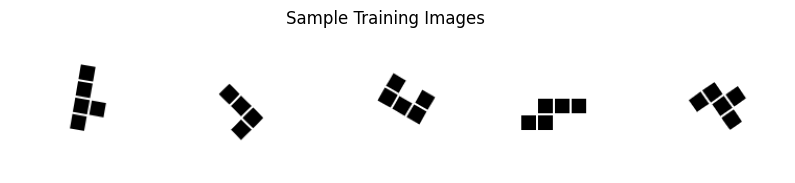

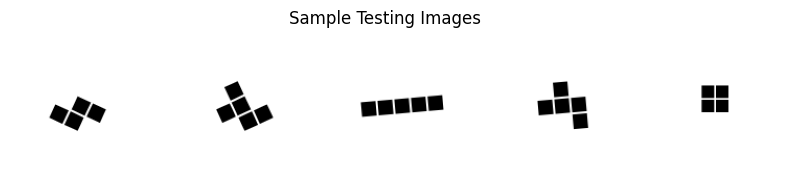

In [54]:
# prompt: plot part of the dataset

import matplotlib.pyplot as plt

# Take the first batch from the training dataset
for batch in train_ds.take(1):
    # The batch is a tensor of images
    images_batch = batch

# Select a few images from the batch to plot
num_images_to_plot = 5
plt.figure(figsize=(10, 2))
for i in range(num_images_to_plot):
    plt.subplot(1, num_images_to_plot, i + 1)
    # Squeeze to remove the channel dimension for grayscale images if needed for plotting
    plt.imshow(tf.squeeze(images_batch[i]).numpy(), cmap='gray')
    plt.axis('off')
plt.suptitle('Sample Training Images')
plt.show()

# Take the first batch from the testing dataset
for batch in test_ds.take(1):
    # The batch is a tensor of images
    images_batch = batch

# Select a few images from the batch to plot
plt.figure(figsize=(10, 2))
for i in range(num_images_to_plot):
    plt.subplot(1, num_images_to_plot, i + 1)
    # Squeeze to remove the channel dimension for grayscale images if needed for plotting
    plt.imshow(tf.squeeze(images_batch[i]).numpy(), cmap='gray')
    plt.axis('off')
plt.suptitle('Sample Testing Images')
plt.show()


Epoch 1/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 22s 76ms/step - kl_loss: 182.4999 - loss: 8605.7109 - reconstruction_loss: 8423.2100 - val_kl_loss: 89.5176 - val_loss: 1576.6010 - val_reconstruction_loss: 1492.3627
Epoch 2/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - kl_loss: 92.7708 - loss: 1450.3816 - reconstruction_loss: 1357.6111 - val_kl_loss: 108.6263 - val_loss: 1286.4449 - val_reconstruction_loss: 1181.4493
Epoch 3/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - kl_loss: 95.6354 - loss: 1169.1163 - reconstruction_loss: 1073.4810 - val_kl_loss: 102.9521 - val_loss: 1106.6873 - val_reconstruction_loss: 1005.0488
Epoch 4/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - kl_loss: 91.7995 - loss: 1026.6790 - reconstruction_loss: 934.8796 - val_kl_loss: 85.7679 - val_loss: 1008.2764 - val_reconstruction_loss: 923.5493
Epoch 5/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - kl_loss: 90.7944 - loss: 973.3981 - reconstruction_loss: 882.6038 - val_kl_loss: 91.1640 - val_loss: 931.9117 - val_reconst

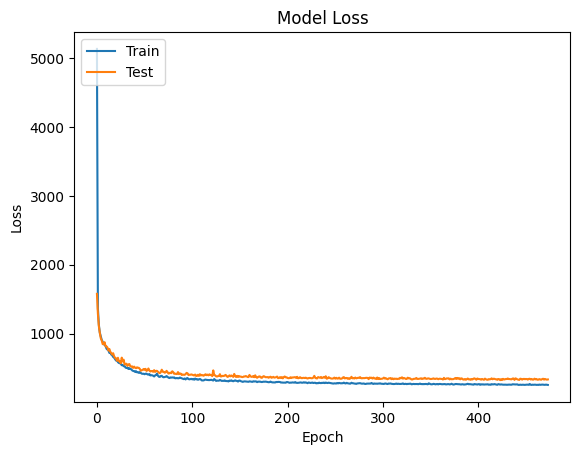

In [55]:
import matplotlib.pyplot as plt

beta_updater_callback = BetaVaeParameterUpdater(delta=2e-4, limit=0.0) # Example values

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     patience=50,
                                                     cooldown=25,
                                                     min_lr=1e-5,
                                                     min_delta=1.0,
                                                     verbose=1)

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                           patience=50,
                                                           restore_best_weights=True,
                                                           min_delta=1.0,
                                                           verbose=1)
terminate_on_nan = tf.keras.callbacks.TerminateOnNaN()

history = model.fit(
    train_ds,
    epochs=1000, # Adjust the number of epochs as needed
    validation_data=test_ds,
    callbacks=[beta_updater_callback, early_stop_callback] # Add the callback
)

# Plot training history (optional)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [58]:
# save the model
model.save(f"bvae_model_ldims_{latent_dims}.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


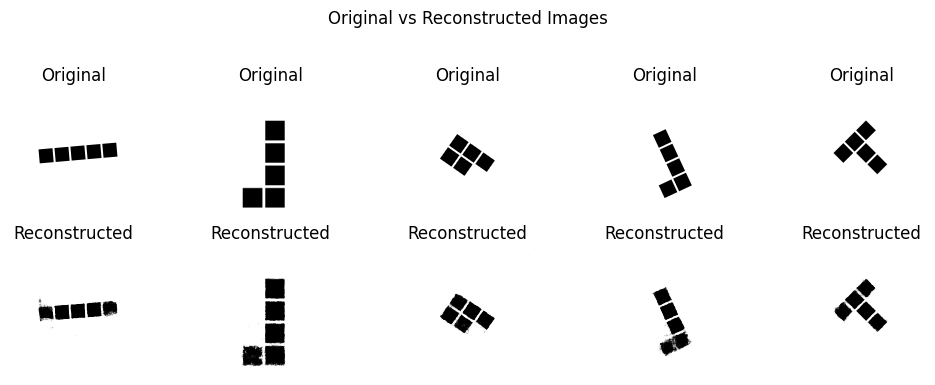

In [56]:
import matplotlib.pyplot as plt
# Select a few images from the test dataset to reconstruct
num_images_to_reconstruct = 5

# Take a batch from the test dataset
for test_batch in test_ds.take(1):
    # Select the first `num_images_to_reconstruct` images from the batch
    original_images = test_batch[:num_images_to_reconstruct]

# Get the reconstructed images from the model
# Ensure the model is built by passing a sample input
model.predict(original_images[:1])
reconstructed_images, _, _ = model(original_images)


# Plot the original and reconstructed images side by side
plt.figure(figsize=(10, 4))
for i in range(num_images_to_reconstruct):
    # Plot original image
    plt.subplot(2, num_images_to_reconstruct, i + 1)
    plt.imshow(tf.squeeze(original_images[i]).numpy(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Plot reconstructed image
    plt.subplot(2, num_images_to_reconstruct, i + 1 + num_images_to_reconstruct)
    plt.imshow(tf.squeeze(reconstructed_images[i]).numpy(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.suptitle('Original vs Reconstructed Images')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlap of title
plt.show()

Generating images by varying latent dimension 0


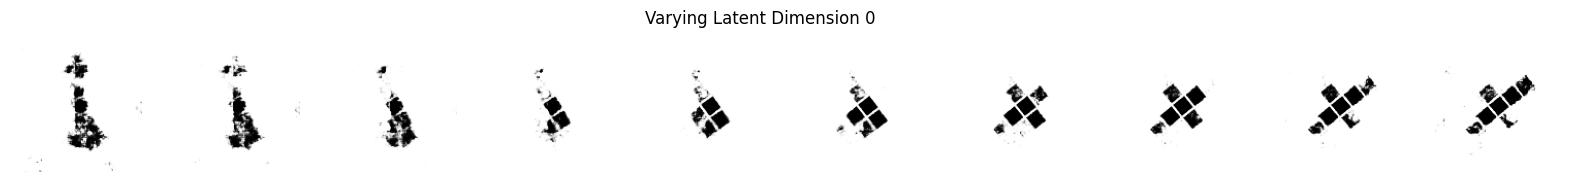

Generating images by varying latent dimension 1


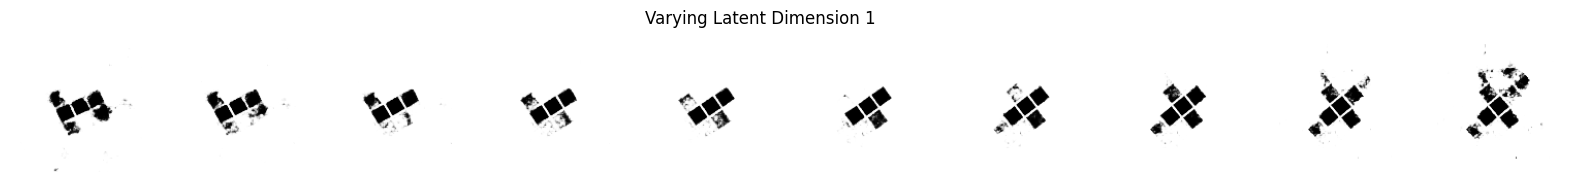

Generating images by varying latent dimension 2


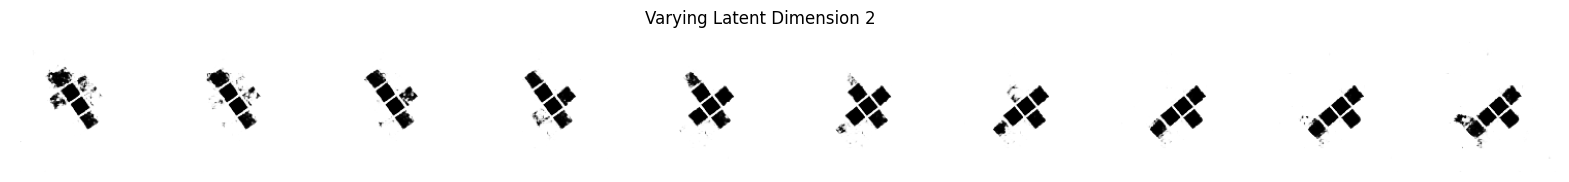

Generating images by varying latent dimension 3


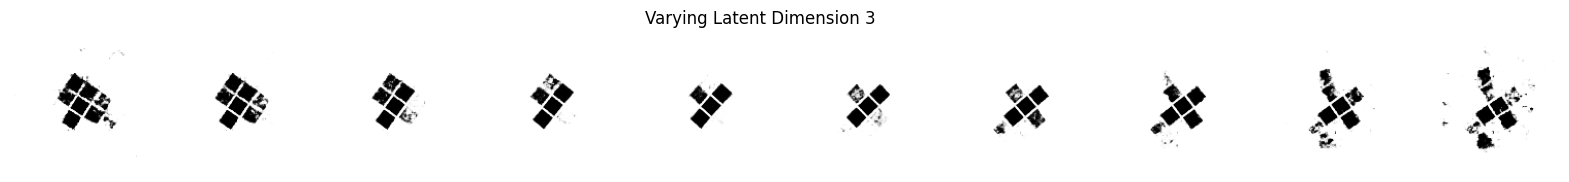

Generating images by varying latent dimension 4


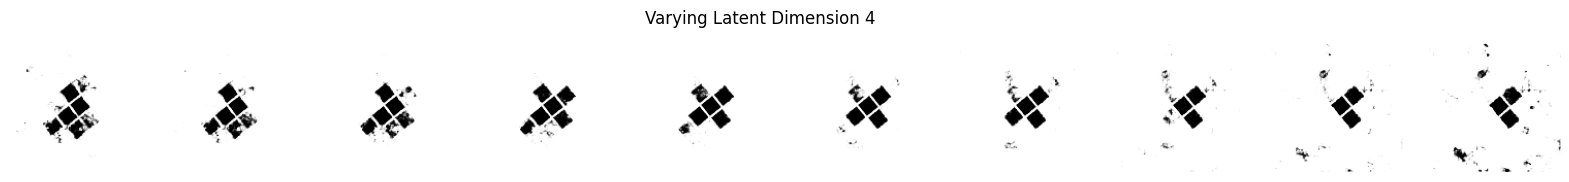

Generating images by varying latent dimension 5


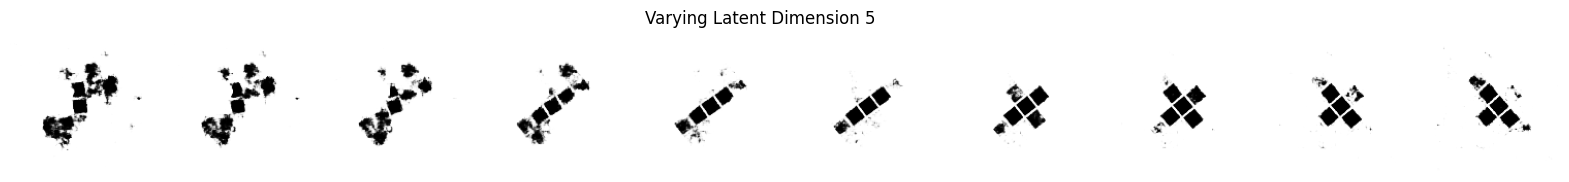

Generating images by varying latent dimension 6


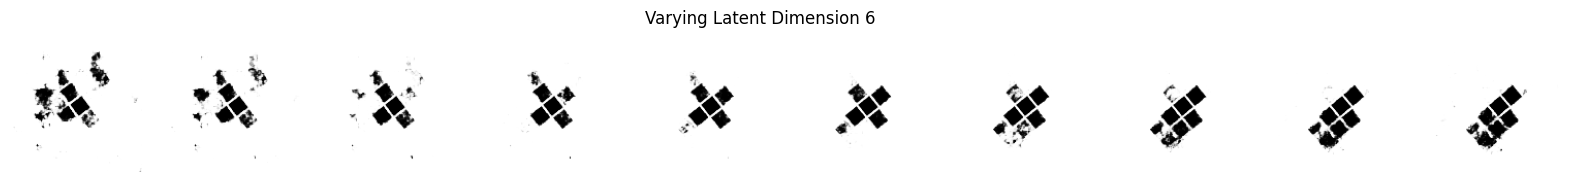

Generating images by varying latent dimension 7


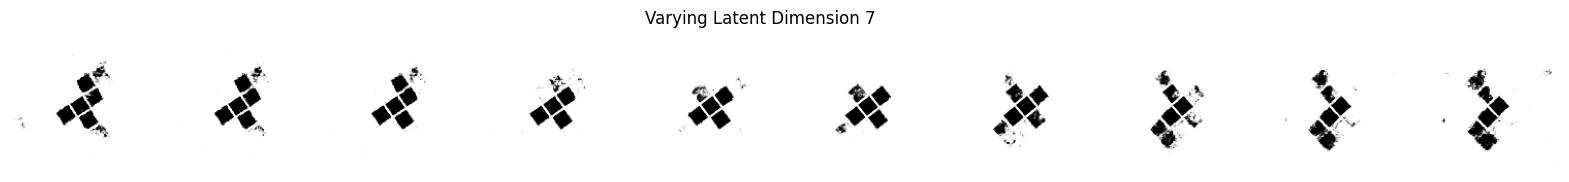

In [57]:
# prompt: create image using the model and move in the latent dimension to show the change in all directions. starting image should be a random image from the latent dimension

import matplotlib.pyplot as plt
import numpy as np
# Function to generate images by moving along a latent dimension
def generate_images_along_latent(model, start_latent_vector, latent_dim_index, steps=10, span=3.0):
    """
    Generates images by varying the value of a specific latent dimension.

    Args:
        model: The trained BVAE model.
        start_latent_vector: The starting point in the latent space (a numpy array).
        latent_dim_index: The index of the latent dimension to vary.
        steps: The number of steps to take along the dimension.
        span: The range to vary the latent dimension value (from -span to +span).

    Returns:
        A list of generated images.
    """
    images = []
    # Create a range of values for the chosen latent dimension
    latent_values = np.linspace(-span, span, steps)

    for value in latent_values:
        # Create a new latent vector by modifying the chosen dimension
        current_latent_vector = np.copy(start_latent_vector)
        current_latent_vector[latent_dim_index] = value

        # Ensure the latent vector has the correct batch dimension for prediction
        current_latent_vector_batch = np.expand_dims(current_latent_vector, axis=0)

        # Decode the latent vector to an image
        generated_image = model.decode(current_latent_vector_batch)

        # Append the image to the list
        images.append(tf.squeeze(generated_image).numpy())

    return images

# Get the latent dimension size from the model
latent_dims = model.latent_dims

# Generate a random latent vector as the starting point
random_latent_vector = np.random.normal(size=(latent_dims,))

# Iterate through each latent dimension and generate images
for dim_index in range(min(latent_dims, 20)):
    print(f"Generating images by varying latent dimension {dim_index}")
    generated_images = generate_images_along_latent(
        model,
        random_latent_vector,
        dim_index,
        steps=10,  # Number of images to generate for this dimension
        span=3.0   # Range of variation in the latent dimension
    )

    # Plot the generated images for the current dimension
    plt.figure(figsize=(len(generated_images) * 2, 2))
    for i, img in enumerate(generated_images):
        plt.subplot(1, len(generated_images), i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Varying Latent Dimension {dim_index}')
    plt.show()

